# Solving a QUBO using QOAO ansatz in qiskit

In [1]:
import sys
sys.path.append('../')
from src.loaddata import LoadData
from src.qubo import Qubo

In [2]:
# LoadData does all the file loading
ld = LoadData()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld)

In [3]:
# use the first slice as an example to solve
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

In [4]:
#QAOA approach

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator, Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')


In [5]:
# QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

from qiskit.circuit.library import TwoLocal
# TwoLocal ansatz circuit
twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

def cost_func(params, ansatz, ising_ham, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    result = estimator.run(ansatz, ising_ham, parameter_values=params).result()
    cost = result.values[0]
    return cost


estimator = Estimator(options={"shots": int(1e4)})
sampler = Sampler(options={"shots": int(1e4)})

In [6]:
#qaoa_ansatz.decompose(reps=1).draw("mpl")

In [7]:
from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
qaoa_ansatz_compiled = transpile(qaoa_ansatz, backend)
print(qaoa_ansatz_compiled.count_ops(), qaoa_ansatz_compiled.depth())

#qaoa_ansatz_compiled.decompose(reps=1).draw("mpl")

OrderedDict([('rzz', 12), ('u2', 4), ('rz', 4), ('rx', 4)]) 16


OrderedDict([('ry', 8), ('cx', 3)]) 5


/Users/farrokhlabib/Documents/github/aquapointer/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


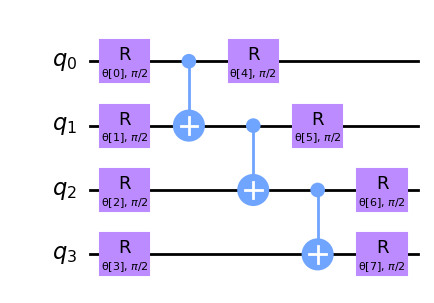

In [8]:
twolocal_ansatz_compiled = transpile(twolocal_ansatz, backend)
print(twolocal_ansatz_compiled.count_ops(), twolocal_ansatz_compiled.depth())
twolocal_ansatz_compiled.decompose(reps=1).draw("mpl")

In [9]:
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
x0 = beta+gamma
# x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
res = minimize(cost_func, x0, args=(qaoa_ansatz, ising_ham, estimator), method="COBYLA")
res

     fun: 0.025054536407446718
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35
  status: 1
 success: True
       x: array([ 0.53713218, -4.01855854])

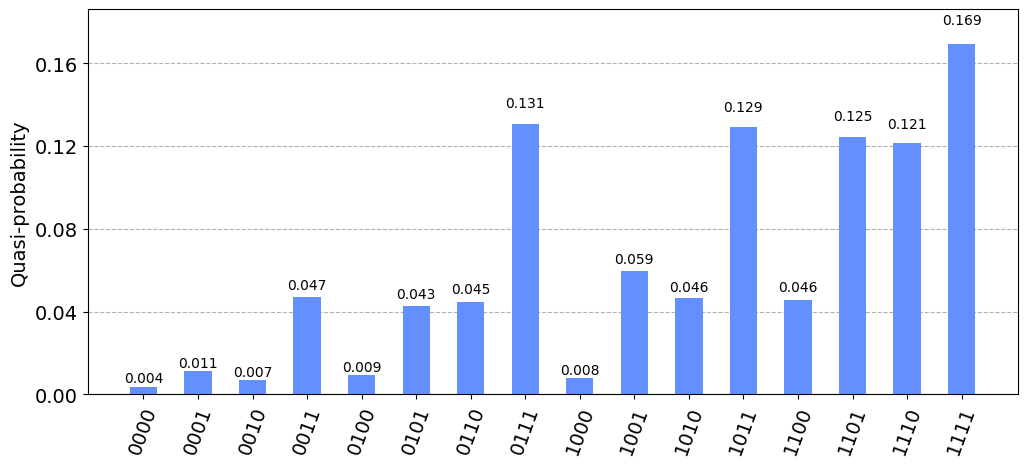

In [10]:
# Assign solution parameters to ansatz
qc = qaoa_ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

plot_distribution(samp_dist.binary_probabilities(), figsize=(12, 5))

In [11]:
# classical brute-force solution
sol, ref_value = q.find_optimum(qubo=qubo)
sol, ref_value

('1000', -0.010743767178636635)

# using vqe.py module

In [12]:
from src.vqe import VQE

# vqe with twolocal ansatz
vqe = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)

In [13]:
res = vqe.run(alpha=1.0)
vqe.cvar_energy(params=vqe.params, alpha=1.0)


   Normal return from subroutine COBYLA

   NFVALS =   89   F =-3.958447E-03    MAXCV = 0.000000E+00
   X = 1.464234E+00   1.517752E+00   1.990755E+00   1.615318E+00   1.649152E+00
       2.817655E+00   2.288570E+00   1.775265E+00


-0.003921013736709481

In [14]:
#vqe with qaoa ansatz
params = beta+gamma
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

In [15]:
res = vqe_qaoa.run(alpha=1.0)
vqe_qaoa.cvar_energy(params=vqe_qaoa.params, alpha=1.0)


   Normal return from subroutine COBYLA

   NFVALS =   33   F = 5.363292E-02    MAXCV = 0.000000E+00
   X = 2.631810E+00   2.361038E+00


0.05090021181912919

In [16]:
vqe_qaoa.cvar_energy(params=vqe_qaoa.params, alpha=0.5)

-0.007477527921532083

In [17]:
from qiskit.primitives import Sampler
sampler = Sampler(options={"shots": int(1e4)})

#apply variational algorithm for different values of alpha, defining the cost function using CVaR
alphas = [1.0, 0.75, 0.5, 0.25, 0.1]

#using linear entanglement ansatz
vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)

#using QAOA ansatz
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = beta+gamma
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

In [18]:
def prob_optimal_solution(vqe_object: VQE, alpha: float, qaoa: bool, optimal_sol: str) -> tuple[float, int]:
    if qaoa:
        params = beta + gamma
        vqe_object.params = params
    else:
        params = np.array([np.random.random()]*vqe_object.ansatz.num_parameters)
        vqe_object.params = params

    res = vqe_object.run(alpha=alpha, method='COBYLA')
    nfev = res.nfev

    # Assign solution parameters to ansatz
    qc = vqe_object.ansatz.assign_parameters(vqe_object.params)
    # Add measurements to our circuit
    qc.measure_all()
    # Sample ansatz at optimal parameters
    samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
    samp_dist_binary = samp_dist.binary_probabilities()
    print(samp_dist_binary)

    correct_dist = {}
    for key in samp_dist_binary.keys():
        reverse_key = key[::-1]
        keynot = [(int(b)+1)%2 for b in reverse_key]
        correct_dist[''.join(map(str, keynot))] = samp_dist_binary[key]
    print(correct_dist)
    return correct_dist.get(optimal_sol), nfev  

In [41]:
prob_optimal_solution(vqe_linear, 0.5, False, '1000')


   Normal return from subroutine COBYLA

   NFVALS =   61   F =-1.074377E-02    MAXCV = 0.000000E+00
   X = 1.017098E+00   2.015894E+00   1.156293E+00   1.658383E+00  -1.414393E-01
       1.031298E+00   1.419586E+00   4.868572E-01
{'0000': 0.0066, '0001': 0.0023, '0010': 0.0013, '0100': 0.0004, '0101': 0.0096, '0110': 0.2082, '0111': 0.0337, '1000': 0.0222, '1001': 0.0081, '1011': 0.0016, '1100': 0.0016, '1101': 0.0347, '1110': 0.5759, '1111': 0.0938}
{'1111': 0.0066, '0111': 0.0023, '1011': 0.0013, '1101': 0.0004, '0101': 0.0096, '1001': 0.2082, '0001': 0.0337, '1110': 0.0222, '0110': 0.0081, '0010': 0.0016, '1100': 0.0016, '0100': 0.0347, '1000': 0.5759, '0000': 0.0938}


(0.5759, 61)

In [ ]:
# just the optimal solution is maybe a bad metric in our application, maybe look at the top 10% of lowest energies and the metric is the sum of their probabilities.